## Aula Treino - Regressão

In [1]:
## importando bibliotecas iniciais

import pandas as pd
import numpy as np


## preprocessamento
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_regression

df_house = pd.read_csv('train_v2.csv')

print(f'O dataset tem {df_house.shape[0]} linhas e {df_house.shape[1]} colunas')
df_house.head()

O dataset tem 1460 linhas e 81 colunas


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [2]:
## checando os valores nulos

df_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Após Verificação De Grande Quantidade De Nulos - Exclusão Desses Dados

In [3]:
missing = df_house.isnull().mean()*100

cols_to_drop = missing[missing > 30].index.tolist()

df_house.drop(cols_to_drop, axis=1, inplace=True)

# Fazendo Separação Entre Treino e Teste

In [4]:
X = df_house.drop(columns=['SalePrice', 'Id'])
y = df_house['SalePrice']

Tínhamos inicialmente 81 colunas, ou seja, não tem como fazer análise exploratória para checar quais colunas utilizar - precisamos implantar um método que otimize isso.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((1168, 73), (292, 73))

# Identificando As Variáveis Categóricas E Numéricas

In [6]:
categorical_var = X_train.select_dtypes(include=['object']).columns
numerical_var = X_train.select_dtypes(include=['number']).columns

categorical_var, numerical_var

(Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
        'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
        'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
        'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
        'SaleType', 'SaleCondition'],
       dtype='object'),
 Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
        'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
        'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
        'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
        'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
        'GarageYrBlt', '

In [7]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.feature_selection import RFE
from category_encoders import OneHotEncoder, TargetEncoder

## Desenvolvendo E Criando O Pipeline

In [8]:
num_pipeline = Pipeline([
    ('imputernum', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputercat', SimpleImputer(strategy='most_frequent')),
    ('encoder', TargetEncoder())  ##alterando estrategia e tirando OneHot e colocando Target
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_pipeline, categorical_var),
        ('num', num_pipeline, numerical_var)
])

from sklearn.linear_model import LinearRegression

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [9]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputercat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   TargetEncoder())]),
                                                  Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'E...
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object'))])),
                ('regressor', LinearRegression())])

In [10]:
# Fazer predições com os dados de teste
y_pred = pipeline.predict(X_test)

import numpy as np
from sklearn.metrics import(
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error)

## comparando as features de teste preditos com o real
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rsme = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

## exibindo as métricas de validação

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RSME: {rsme:.2f}')
print(f'MAPE: {mape:.2f}')


MAE: 19785.23
MSE: 985504865.11
RSME: 31392.75
MAPE: 0.12


Grande problema inicialmente foi usar o OneHotEncoder - que gerou muitas colunas extras tendo poucas observações, isso pode ter levado o modelo ao overfiting.

# 2° Tentativa - Melhoria Do Modelo.

In [11]:
## pip install --upgrade category_encoders

In [12]:
## pip install --upgrade matplotlib

In [13]:
## pip install --upgrade scikit-learn

In [17]:
from category_encoders import OneHotEncoder, TargetEncoder, CatBoostEncoder ## WoEEncoder -> apenas para binário ## testando novos encoders
from sklearn.ensemble import GradientBoostingRegressor    ## testando um modelo ensemble

num_pipeline = Pipeline([
    ('imputernum', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputercat', SimpleImputer(strategy='most_frequent')),
    ('encoder', CatBoostEncoder())  ## alterando estrategia 
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_pipeline, categorical_var),
        ('num', num_pipeline, numerical_var)
])

#pipeline = Pipeline([
#    ('preprocessor', preprocessor),
#    ('rfe', RFE(RandomForestRegressor(),n_estimators = 50, n_features_to_select = 40)), ## recursive feature elimination - retira as variáveis menos importantes
#    ('regressor', GradientBoostingRegressor())  ## mudança de modelo - utilização de um ensemble
#])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rfe', RFE(RandomForestRegressor(n_estimators=50), n_features_to_select=40)), 
    ('regressor', GradientBoostingRegressor()) 
])

pipeline.fit(X_train, y_train)

# Fazer predições com os dados de teste
y_pred = pipeline.predict(X_test)

## comparando as features de teste preditos com o real
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rsme = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

## exibindo as métricas de validação

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RSME: {rsme:.2f}')
print(f'MAPE: {mape:.2f}')

MAE: 16135.94
MSE: 694530961.32
RSME: 26353.96
MAPE: 0.10


## Finalizando Gráfico - Predição x Real

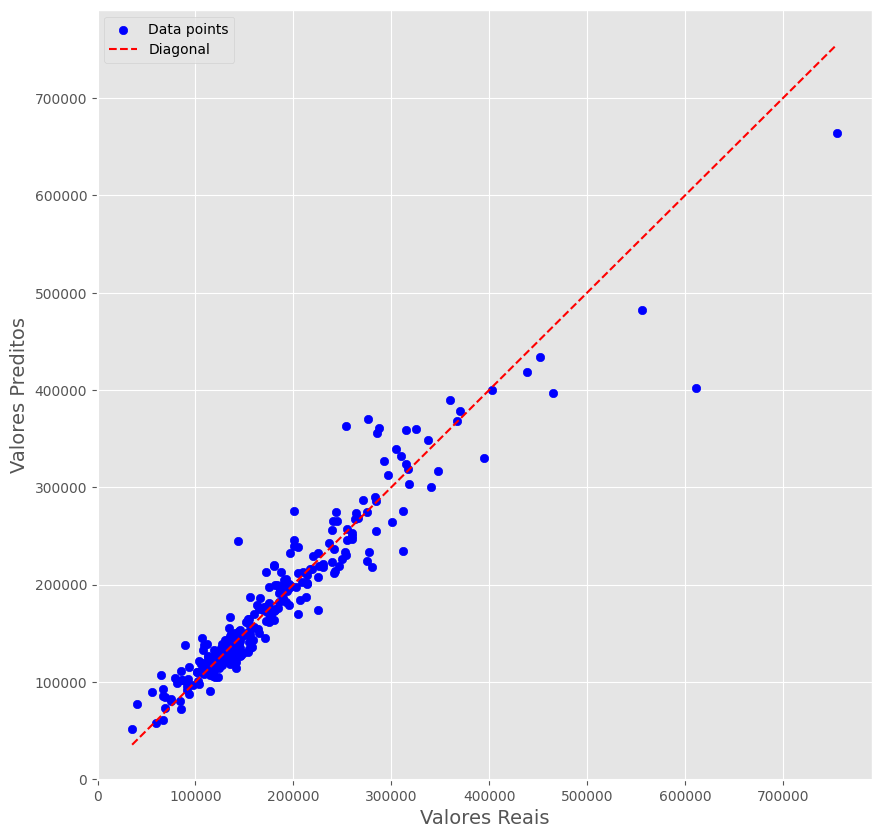

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.style.use('ggplot')

plt.scatter(y_test, y_pred, c='blue', label='Data points')

plt.xlabel('Valores Reais', fontsize = 14)
plt.ylabel('Valores Preditos', fontsize = 14)

min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label = 'Diagonal')

plt.legend()

plt.show()